  2%|▏         | 37/2000 [00:07<03:13, 10.14it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 2000/2000 [02:12<00:00, 15.06it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 589ms/step - accuracy: 0.0135 - loss: 4.0004 - val_accuracy: 0.0125 - val_loss: 3.9044
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 591ms/step - accuracy: 0.0348 - loss: 3.8071 - val_accuracy: 0.0550 - val_loss: 3.6293
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 787ms/step - accuracy: 0.0533 - loss: 3.5863 - val_accuracy: 0.0825 - val_loss: 3.4734
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 630ms/step - accuracy: 0.0866 - loss: 3.3718 - val_accuracy: 0.1100 - val_loss: 3.2380
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 565ms/step - accuracy: 0.1471 - loss: 3.1797 - val_accuracy: 0.2100 - val_loss: 2.7865
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 572ms/step - accuracy: 0.2237 - loss: 2.7183 - val_accuracy: 0.2450 - val_loss: 2.6369
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 567ms/step - accuracy: 0.2915 - loss: 2.5106 - val_accuracy: 0.2575 - val_loss: 2.4720
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 570ms/step - accuracy: 0.3322 - loss: 2.2614 - 

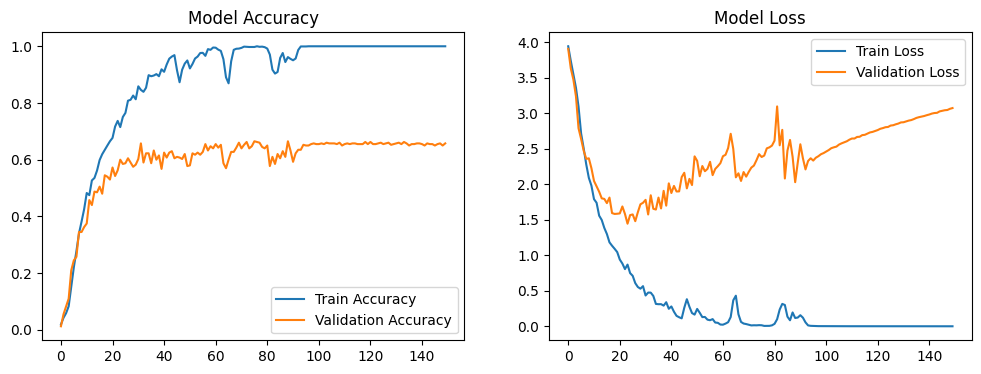

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.6481 - loss: 3.5635
Test Accuracy: 0.6575
Final Test Accuracy: 0.6575
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Accuracy: 1.0000
Validation Accuracy: 0.6575
Precision: 0.6871
Recall: 0.6575
F1-score: 0.6583
ESC-50 pre-trained model saved successfully!


In [ ]:
###  Log-Mel Spectrogram (LM), Spectral Contrast (SPC), and Chroma (CH)

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load ESC-50 metadata
esc50_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/meta/esc50.csv"
esc50_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/audio"

metadata = pd.read_csv(esc50_csv_path)

# Function to extract stacked features (LM + SPC + CH)
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)

        def resize_feature(feature, target_size):
            return np.pad(feature, ((0, max(0, target_size[0] - feature.shape[0])),
                                     (0, max(0, target_size[1] - feature.shape[1]))), mode='constant')

        mel_spec = resize_feature(mel_spec, target_size)
        spectral_contrast = resize_feature(spectral_contrast, target_size)
        chroma = resize_feature(chroma, target_size)

        stacked_features = np.stack([mel_spec, spectral_contrast, chroma], axis=-1)
        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Prepare dataset
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_path = os.path.join(esc50_audio_dir, metadata.loc[i, "filename"])
    label = metadata.loc[i, "target"]

    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = to_categorical(y, num_classes=50)

# Resize images (Ensure uniformity)
X_resized = np.array([tf.image.resize(img, (128, 128)).numpy() for img in X])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

# Define CNN model based on the paper
def create_cnn_model(input_shape, num_classes=50):
    model = Sequential([
        Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(32, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (2, 2), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),

        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Train the CNN model
input_shape = (128, 128, 3)
num_classes = 50
model = create_cnn_model(input_shape, num_classes)

# Train model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Print final test accuracy
print(f"Final Test Accuracy: {accuracy:.4f}")


from sklearn.metrics import classification_report, accuracy_score

# Extract final training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert softmax outputs to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to class labels

# Compute classification metrics
report = classification_report(y_true, y_pred, digits=4, output_dict=True)

# Extract precision, recall, and F1-score
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")


# Save ESC-50 trained model
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_SPC_CH_ESC50.h5"
model.save(esc50_model_path)
print("ESC-50 pre-trained model saved successfully!")


  1%|          | 67/8732 [00:08<09:48, 14.72it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 41%|████      | 3555/8732 [04:40<05:21, 16.11it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8326/8732 [10:37<00:35, 11.48it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8329/8732 [10:37<00:27, 14.63it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [11:04<00:00, 13.14it/s]


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 65s 283ms/step - accuracy: 0.3003 - loss: 2.3655 - val_accuracy: 0.5650 - val_loss: 1.2357
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 281ms/step - accuracy: 0.5874 - loss: 1.1724 - val_accuracy: 0.6669 - val_loss: 1.0283
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 83s 286ms/step - accuracy: 0.6748 - loss: 0.9560 - val_accuracy: 0.6966 - val_loss: 0.9203
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - accuracy: 0.7250 - loss: 0.8700 - val_accuracy: 0.7161 - val_loss: 0.8681
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 228ms/step - accuracy: 0.7372 - loss: 0.8060 - val_accuracy: 0.7218 - val_loss: 0.8178
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 84s 238ms/step - accuracy: 0.7711 - loss: 0.7415 - val_accuracy: 0.7527 - val_loss: 0.7795
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 234ms/step - accuracy: 0.7760 - loss: 0.7308 - val_accuracy: 0.7602 - val_loss: 0.7427
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 88s 262ms/step - accuracy: 0.7935 - loss: 0

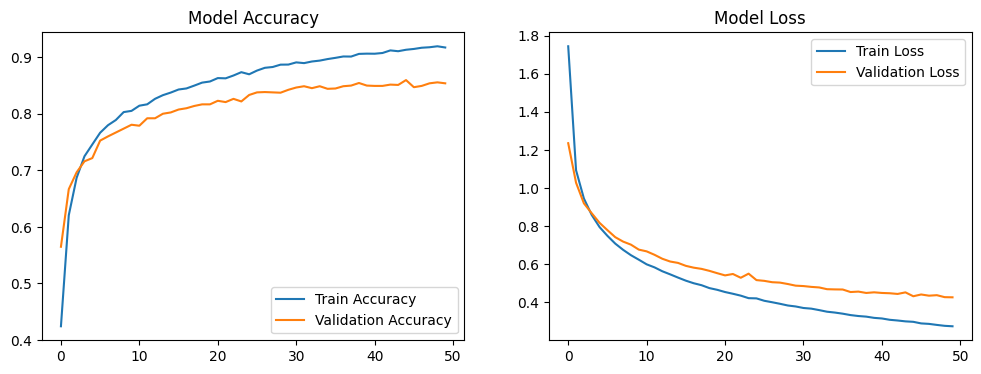

Fine-tuned model saved successfully!


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

# Define Paths
urbansound_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_SPC_CH_ESC50.h5"

# Load UrbanSound8K Metadata
urbansound_metadata = pd.read_csv(urbansound_csv_path)

# Function to extract stacked features (LM + SPC + CH)
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)

        def resize_feature(feature, target_size):
            # Standardize width to 128 using librosa.util.fix_length
            feature = librosa.util.fix_length(feature, size=target_size[1], axis=1)
            # Standardize height to 128 using zero-padding or truncation
            if feature.shape[0] < target_size[0]:  # Pad height if needed
                pad_amount = target_size[0] - feature.shape[0]
                feature = np.pad(feature, ((0, pad_amount), (0, 0)), mode='constant')
            elif feature.shape[0] > target_size[0]:  # Trim height if too large
                feature = feature[:target_size[0], :]
            return feature

        # Resize features
        mel_spec = resize_feature(mel_spec, target_size)
        spectral_contrast = resize_feature(spectral_contrast, target_size)
        chroma = resize_feature(chroma, target_size)

        stacked_features = np.stack([mel_spec, spectral_contrast, chroma], axis=-1)

        # Final shape check
        if stacked_features.shape != (128, 128, 3):
            print(f"Unexpected shape: {stacked_features.shape} for file {file_path}")
            return None

        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Prepare dataset
X, y = [], []
for i in tqdm(range(len(urbansound_metadata))):
    fold = f"fold{urbansound_metadata.loc[i, 'fold']}"
    file_name = urbansound_metadata.loc[i, "slice_file_name"]
    file_path = os.path.join(urbansound_audio_dir, fold, file_name)
    label = urbansound_metadata.loc[i, "classID"]

    features = extract_features(file_path)

    # Ensure valid feature extraction before adding
    if features is not None and features.shape == (128, 128, 3):
        X.append(features)
        y.append(label)

# Convert to NumPy array
X = np.array(X, dtype=np.float32)
y = to_categorical(y, num_classes=10)  # UrbanSound8K has 10 classes

# Resize images to ensure uniformity
X_resized = np.array([tf.image.resize(img, (128, 128)).numpy() for img in X])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

# Load the pre-trained ESC-50 Model
model = load_model(esc50_model_path)

# Modify the last layer for UrbanSound8K (10 Classes)
# Remove the last Dense layer by recreating the model
new_model = tf.keras.models.Sequential()

# Copy all layers except the last one
for layer in model.layers[:-1]:  # Exclude last layer
    new_model.add(layer)

# Ensure previous layers are frozen (except last few)
for layer in new_model.layers[:-3]:  # Freeze all except last 3 layers
    layer.trainable = False

# Add a new Dense layer for UrbanSound8K classification
new_model.add(tf.keras.layers.Dense(10, activation='softmax', name="urban_sound_output"))

# Compile the model
new_model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Assign the updated model back to `model`
model = new_model

# Train the model on UrbanSound8K
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Fine-tuned Model Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# Save fine-tuned model
urbansound_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_SPC_CH_UrbanSound8K.h5"
model.save(urbansound_model_path)
print("Fine-tuned model saved successfully!")


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Extract final training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert softmax outputs to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to class labels

# Compute classification metrics
report = classification_report(y_true, y_pred, digits=4, output_dict=True)

# Extract precision, recall, and F1-score
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

# Print detailed classification report
print("\nDetailed Classification Report:\n", classification_report(y_true, y_pred, digits=4))

# Save classification report as a CSV file (optional)
import pandas as pd
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("/content/drive/MyDrive/Colab Notebooks/saved_models/classification_report.csv")
print("Classification report saved successfully!")


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step
Training Accuracy: 0.9174
Validation Accuracy: 0.8540
Precision: 0.8551
Recall: 0.8540
F1-score: 0.8539

Detailed Classification Report:
               precision    recall  f1-score   support

           0     0.8647    0.8818    0.8732       203
           1     0.8082    0.6860    0.7421        86
           2     0.7512    0.8251    0.7865       183
           3     0.8287    0.8905    0.8585       201
           4     0.8804    0.8932    0.8867       206
           5     0.8811    0.8446    0.8624       193
           6     0.9857    0.9583    0.9718        72
           7     0.9024    0.8894    0.8959       208
           8     0.8773    0.8667    0.8720       165
           9     0.8257    0.7826    0.8036       230

    accuracy                         0.8540      1747
   macro avg     0.8606    0.8518    0.8553      1747
weighted avg     0.8551    0.8540    0.8539      1747

Classification report saved successfully!


  1%|          | 67/8732 [00:52<1:51:04,  1.30it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 41%|████      | 3555/8732 [21:37<28:33,  3.02it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8326/8732 [48:59<02:19,  2.92it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8329/8732 [48:59<01:48,  3.72it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [51:11<00:00,  2.84it/s]


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 47s 204ms/step - accuracy: 0.2664 - loss: 2.6439 - val_accuracy: 0.5827 - val_loss: 1.2183
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 46s 209ms/step - accuracy: 0.6071 - loss: 1.1454 - val_accuracy: 0.6491 - val_loss: 1.0231
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 80s 200ms/step - accuracy: 0.6649 - loss: 0.9870 - val_accuracy: 0.6875 - val_loss: 0.9113
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 195ms/step - accuracy: 0.7034 - loss: 0.8805 - val_accuracy: 0.7155 - val_loss: 0.8508
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 84s 206ms/step - accuracy: 0.7402 - loss: 0.7944 - val_accuracy: 0.7207 - val_loss: 0.8042
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 80s 199ms/step - accuracy: 0.7539 - loss: 0.7617 - val_accuracy: 0.7470 - val_loss: 0.7634
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 194ms/step - accuracy: 0.7788 - loss: 0.7045 - val_accuracy: 0.7413 - val_loss: 0.7500
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 46s 211ms/step - accuracy: 0.7986 - loss: 0

Fine-tuned Model Test Accuracy: 0.8626
Fine-tuned model saved successfully!


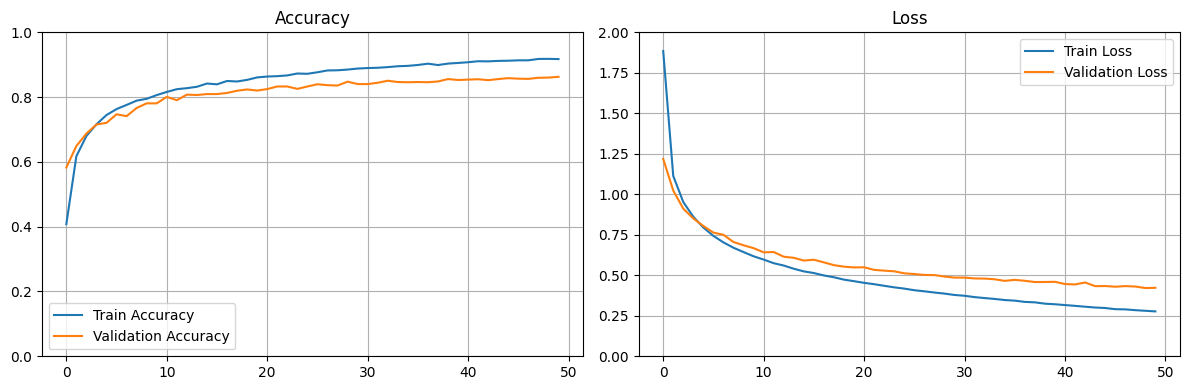

CNN1 training history saved!


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

# Define Paths
urbansound_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_SPC_CH_ESC50.h5"

# Load UrbanSound8K Metadata
urbansound_metadata = pd.read_csv(urbansound_csv_path)

# Function to extract stacked features (LM + SPC + CH)
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)

        def resize_feature(feature, target_size):
            # Standardize width to 128 using librosa.util.fix_length
            feature = librosa.util.fix_length(feature, size=target_size[1], axis=1)
            # Standardize height to 128 using zero-padding or truncation
            if feature.shape[0] < target_size[0]:  # Pad height if needed
                pad_amount = target_size[0] - feature.shape[0]
                feature = np.pad(feature, ((0, pad_amount), (0, 0)), mode='constant')
            elif feature.shape[0] > target_size[0]:  # Trim height if too large
                feature = feature[:target_size[0], :]
            return feature

        # Resize features
        mel_spec = resize_feature(mel_spec, target_size)
        spectral_contrast = resize_feature(spectral_contrast, target_size)
        chroma = resize_feature(chroma, target_size)

        stacked_features = np.stack([mel_spec, spectral_contrast, chroma], axis=-1)

        # Final shape check
        if stacked_features.shape != (128, 128, 3):
            print(f"Unexpected shape: {stacked_features.shape} for file {file_path}")
            return None

        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Prepare dataset
X, y = [], []
for i in tqdm(range(len(urbansound_metadata))):
    fold = f"fold{urbansound_metadata.loc[i, 'fold']}"
    file_name = urbansound_metadata.loc[i, "slice_file_name"]
    file_path = os.path.join(urbansound_audio_dir, fold, file_name)
    label = urbansound_metadata.loc[i, "classID"]

    features = extract_features(file_path)

    # Ensure valid feature extraction before adding
    if features is not None and features.shape == (128, 128, 3):
        X.append(features)
        y.append(label)

# Convert to NumPy array
X = np.array(X, dtype=np.float32)
y = to_categorical(y, num_classes=10)  # UrbanSound8K has 10 classes

# Resize images to ensure uniformity
X_resized = np.array([tf.image.resize(img, (128, 128)).numpy() for img in X])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

# Load the pre-trained ESC-50 Model
model = load_model(esc50_model_path)

# Modify the last layer for UrbanSound8K (10 Classes)
# Remove the last Dense layer by recreating the model
new_model = tf.keras.models.Sequential()

# Copy all layers except the last one
for layer in model.layers[:-1]:  # Exclude last layer
    new_model.add(layer)

# Ensure previous layers are frozen (except last few)
for layer in new_model.layers[:-3]:  # Freeze all except last 3 layers
    layer.trainable = False

# Add a new Dense layer for UrbanSound8K classification
new_model.add(tf.keras.layers.Dense(10, activation='softmax', name="urban_sound_output"))

# Compile the model
new_model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Assign the updated model back to `model`
model = new_model

# Train the model on UrbanSound8K
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Fine-tuned Model Test Accuracy: {accuracy:.4f}")


# Save fine-tuned model
urbansound_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN1_LM_SPC_CH_UrbanSound8K.h5"
model.save(urbansound_model_path)
print("Fine-tuned model saved successfully!")


# Plot Training History
# ============================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0, 1)
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim(0, 2)
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ============================
# Save Training History as .npy
# ============================
result_dir = "/content/drive/MyDrive/Colab Notebooks/Models/Result"
np.save(os.path.join(result_dir, "cnn1_LM_SPC_CH_train_acc.npy"), history.history['accuracy'])
np.save(os.path.join(result_dir, "cnn1_LM_SPC_CH_val_acc.npy"), history.history['val_accuracy'])
np.save(os.path.join(result_dir, "cnn1_LM_SPC_CH_train_loss.npy"), history.history['loss'])
np.save(os.path.join(result_dir, "cnn1_LM_SPC_CH_val_loss.npy"), history.history['val_loss'])

print("CNN1 training history saved!")
